# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from scipy.stats import entropy, wasserstein_distance, ks_2samp

## Fixing Target values

In [2]:
# Combine features and target into a single DataFrame
df = pd.read_csv('data.csv', delimiter=';')

# Encode target variable
mapping = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}
df['Target_encoded'] = df['Target'].map(mapping)

In [3]:
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Target_encoded
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate,0
4420,1,1,2,9773,1,1,120.0,105,1,1,...,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout,1
4421,1,1,1,9500,1,1,154.0,1,37,37,...,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout,1
4422,1,1,1,9147,1,1,180.0,1,37,37,...,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate,0


## Train-test spliting for original dataset

In [4]:
# Drop the original target column
df = df.drop('Target', axis=1)

# Split the data into features and target
X = df.drop(columns=['Target_encoded'])
y = df['Target_encoded']

# Split the data into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=17)

# Basic and Advanced params for models

In [5]:
# Define common parameters for models
common_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'n_estimators': 200
}

In [6]:

catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 8,
    'l2_leaf_reg': 3,
    'border_count': 128,
    'verbose': 0
}

# XGBoost-specific parameters
xgboost_params = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Random Forest-specific parameters
randomforest_params = {
    'n_estimators': 500,
    'max_depth': 12,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True
}

# Models with basic params and advanced ones

In [7]:
# Define models
models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=17),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=17),
    'RandomForest': RandomForestClassifier(random_state=17)
}

In [8]:
better_models = {
    'CatBoost': CatBoostClassifier(random_state=17, **catboost_params),
    'XGBoost': XGBClassifier(random_state=17, **xgboost_params),
    'RandomForest': RandomForestClassifier(random_state=17, **randomforest_params)
}

# Evaluating model function

In [9]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba
    }

In [10]:
# Evaluate models on full dataset
results_full = {}
for model_name, model in models.items():
    print(f"Training {model_name} on full dataset...")
    results_full[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on full dataset...
Training XGBoost on full dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:32:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on full dataset...


# Plotting results for Original Dataset
## *Basic params*

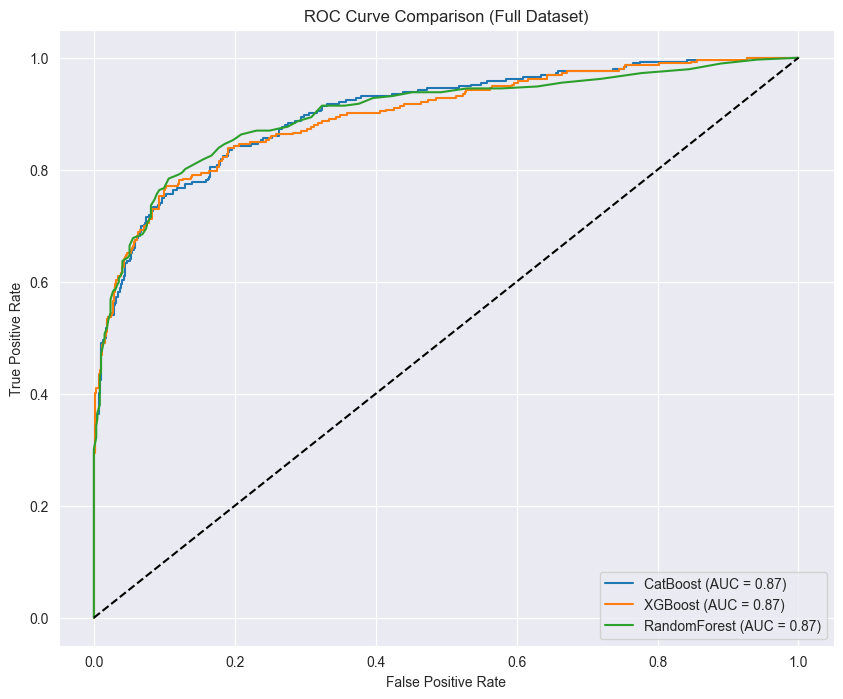

In [11]:
# Plot ROC curves for full dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_full.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Full Dataset)')
plt.legend(loc='lower right')
plt.show()

In [12]:
results_full_better = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} on full dataset...")
    results_full_better[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on full dataset...
Training XGBoost on full dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:32:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on full dataset...


## *Advanced params*

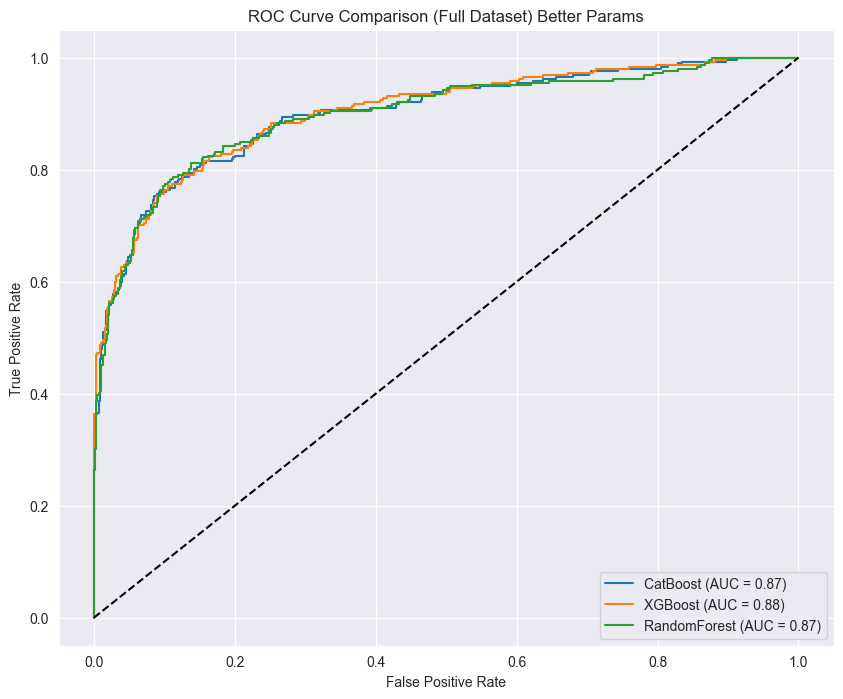

In [13]:
# Plot ROC curves for full dataset
plt.figure(figsize=(10, 8))
for better_model_name, better_result in results_full_better.items():
    fpr, tpr, _ = roc_curve(y_test_full, better_result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{better_model_name} (AUC = {better_result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Full Dataset) Better Params')
plt.legend(loc='lower right')
plt.show()

In [14]:
# Print results for full dataset
for model_name, result in results_full.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7419
Recall: 0.7503
F1-Score: 0.7441
ROC-AUC: 0.8726

Model: XGBoost
Accuracy: 0.7469
Precision: 0.7400
Recall: 0.7469
F1-Score: 0.7407
ROC-AUC: 0.8713

Model: RandomForest
Accuracy: 0.7729
Precision: 0.7652
Recall: 0.7729
F1-Score: 0.7631
ROC-AUC: 0.8745


In [15]:
for better_model_name, better_result in results_full_better.items():
    print(f"\nModel: {better_model_name}")
    print(f"Accuracy: {better_result['accuracy']:.4f}")
    print(f"Precision: {better_result['precision']:.4f}")
    print(f"Recall: {better_result['recall']:.4f}")
    print(f"F1-Score: {better_result['f1']:.4f}")
    print(f"ROC-AUC: {better_result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8780

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7507
Recall: 0.7650
F1-Score: 0.7509
ROC-AUC: 0.8702


# Making sliced dataset

In [16]:
# Slice the dataset
df_sliced = df.sample(frac=0.1, random_state=17)
X_sliced = df_sliced.drop('Target_encoded', axis=1)
y_sliced = df_sliced['Target_encoded']

In [17]:
# Split the sliced data into training and testing sets
X_train_sliced, X_test_sliced, y_train_sliced, y_test_sliced = train_test_split(X_sliced, y_sliced, test_size=0.2, random_state=17)

In [18]:
# Evaluate models on sliced dataset
results_sliced = {}
for model_name, model in models.items():
    print(f"Training {model_name} on sliced dataset...")
    results_sliced[model_name] = evaluate_model(model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

Training CatBoost on sliced dataset...
Training XGBoost on sliced dataset...
Training RandomForest on sliced dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
better_results_sliced = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} on sliced dataset...")
    better_results_sliced[better_model_name] = evaluate_model(better_model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

Training CatBoost on sliced dataset...
Training XGBoost on sliced dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on sliced dataset...


# *Slicecd Dataset*
## *Basic params*

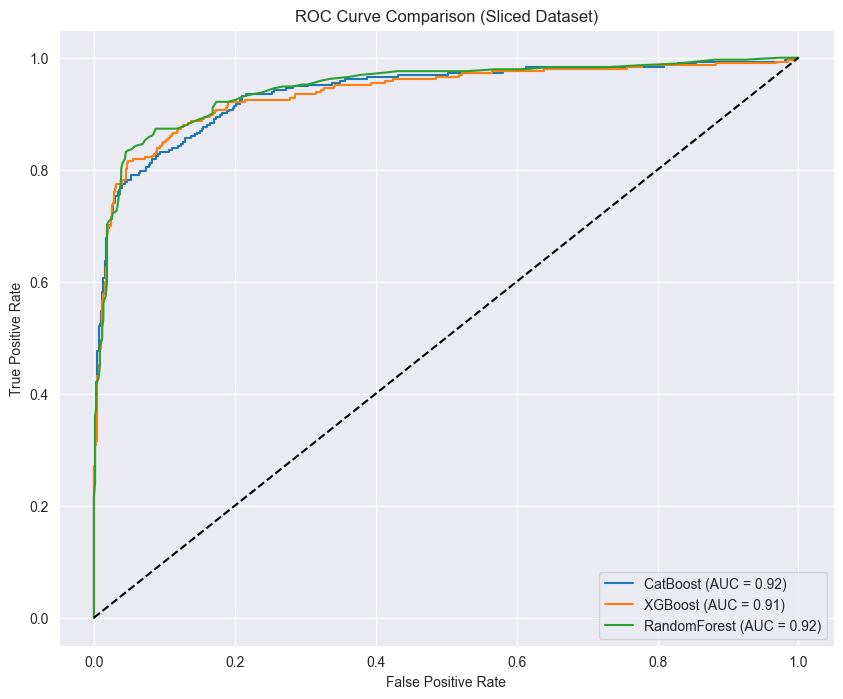

In [20]:
# Plot ROC curves for sliced dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_sliced.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Sliced Dataset)')
plt.legend(loc='lower right')
plt.show()

## *Advanced params*

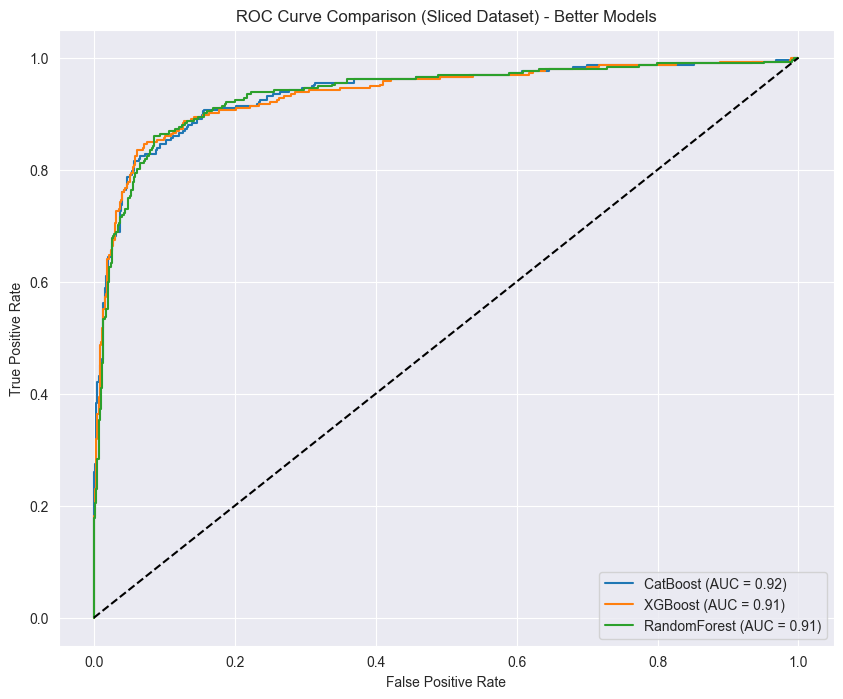

In [21]:
plt.figure(figsize=(10, 8))
for better_model_name, better_result in better_results_sliced.items():
    fpr, tpr, _ = roc_curve(y_test_full, better_result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{better_model_name} (AUC = {better_result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Sliced Dataset) - Better Models')
plt.legend(loc='lower right')
plt.show()

In [22]:
# Print results for sliced dataset
for model_name, result in results_sliced.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.8192
Precision: 0.8154
Recall: 0.8192
F1-Score: 0.8117
ROC-AUC: 0.9206

Model: XGBoost
Accuracy: 0.8249
Precision: 0.8195
Recall: 0.8249
F1-Score: 0.8204
ROC-AUC: 0.9149

Model: RandomForest
Accuracy: 0.8328
Precision: 0.8295
Recall: 0.8328
F1-Score: 0.8237
ROC-AUC: 0.9248


In [23]:
# Print results for sliced dataset
for better_model_name, better_result in better_results_sliced.items():
    print(f"\nModel: {better_model_name}")
    print(f"Accuracy: {better_result['accuracy']:.4f}")
    print(f"Precision: {better_result['precision']:.4f}")
    print(f"Recall: {better_result['recall']:.4f}")
    print(f"F1-Score: {better_result['f1']:.4f}")
    print(f"ROC-AUC: {better_result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.8237
Precision: 0.8285
Recall: 0.8237
F1-Score: 0.8109
ROC-AUC: 0.9176

Model: XGBoost
Accuracy: 0.8271
Precision: 0.8225
Recall: 0.8271
F1-Score: 0.8190
ROC-AUC: 0.9103

Model: RandomForest
Accuracy: 0.8226
Precision: 0.8232
Recall: 0.8226
F1-Score: 0.8090
ROC-AUC: 0.9131


# Saving sliced dataset

In [24]:
# Save the sliced dataset to a CSV file
df_sliced.to_csv('D:/LLM_exp/df_sliced.csv', index=False)

# Chat-GPT generated dataset

In [25]:
# Load the synthetic dataset generated by GPT
df_gpt = pd.read_csv('D:/LLM_exp/synthetic_dataset.csv')

In [26]:
# Evaluate models on GPT-generated dataset
results_gpt = {}
for model_name, model in models.items():
    print(f"Training {model_name} on GPT-generated dataset...")
    results_gpt[model_name] = evaluate_model(model, X_train_full, y_train_full, X_test_full, y_test_full)

Training CatBoost on GPT-generated dataset...
Training XGBoost on GPT-generated dataset...
Training RandomForest on GPT-generated dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# *GPT-dataset basic params*

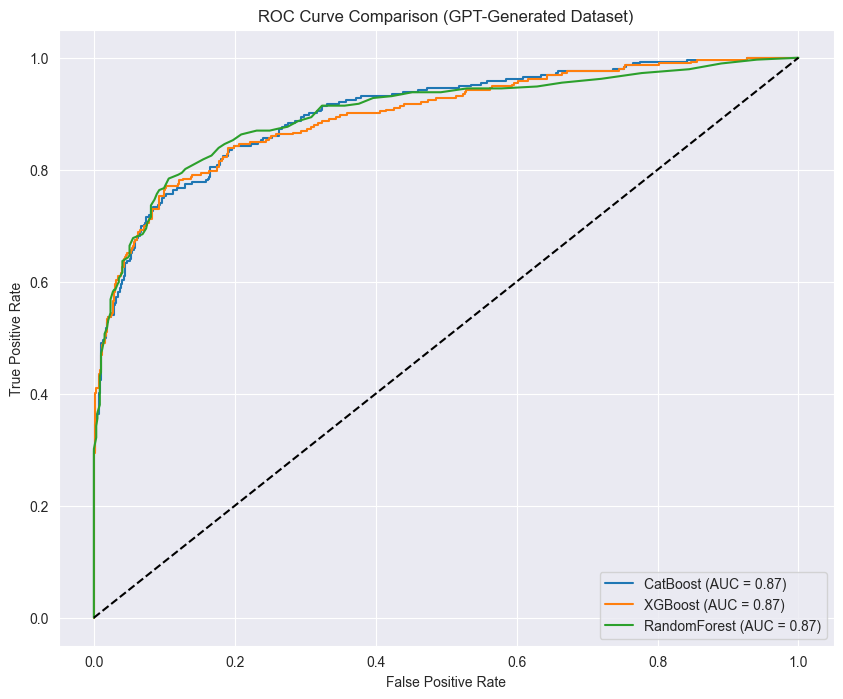

In [27]:
# Plot ROC curves for GPT-generated dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_gpt.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (GPT-Generated Dataset)')
plt.legend(loc='lower right')
plt.show()

In [28]:
# Print results for GPT-generated dataset
for model_name, result in results_gpt.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Model: CatBoost
Accuracy: 0.7503
Precision: 0.7419
Recall: 0.7503
F1-Score: 0.7441
ROC-AUC: 0.8726

Model: XGBoost
Accuracy: 0.7469
Precision: 0.7400
Recall: 0.7469
F1-Score: 0.7407
ROC-AUC: 0.8713

Model: RandomForest
Accuracy: 0.7729
Precision: 0.7652
Recall: 0.7729
F1-Score: 0.7631
ROC-AUC: 0.8745


## *Deepseek function for generation samples*

In [29]:
# Function to generate a new dataset using resampling (Deepseek)
def generate_new_dataset(original_df, multiplier=10):
    new_data = []
    for _ in range(multiplier):
        resampled_df = resample(original_df, replace=True, n_samples=len(original_df), random_state=np.random.randint(0, 100))
        new_data.append(resampled_df)
    return pd.concat(new_data, ignore_index=True)

## *Copilot function for generation samples (with the second prompt)*

In [30]:
# Function to generate synthetic data (Copilot)
def generate_synthetic_data(data, size_multiplier=10):
    synthetic_data = pd.DataFrame()
    for col in data.columns:
        if col == "Target_encoded":
            synthetic_data[col] = np.random.choice([0, 1, 2], len(data) * size_multiplier)
        elif data[col].dtype in [np.float64, np.int64]:
            synthetic_data[col] = np.random.normal(data[col].mean(), data[col].std(), len(data) * size_multiplier)
        else:
            synthetic_data[col] = np.random.choice(data[col], len(data) * size_multiplier)
    return synthetic_data


In [31]:
# Load the sliced dataset
df_sliced = pd.read_csv('df_sliced.csv')

# Generate deepseek dataset using resampling
df_deepseek = generate_new_dataset(df_sliced, multiplier=10)

# Generate copilot dataset using synthetic data generation
df_copilot = generate_synthetic_data(df_sliced)

## *Dataset preparation*

In [32]:

# Prepare datasets for training and testing
def prepare_datasets(df):
    X = df.drop('Target_encoded', axis=1)
    y = df['Target_encoded']
    return train_test_split(X, y, test_size=0.2, random_state=17)


In [33]:
X_train_deepseek, X_test_deepseek, y_train_deepseek, y_test_deepseek = prepare_datasets(df_deepseek)
X_train_copilot, X_test_copilot, y_train_copilot, y_test_copilot = prepare_datasets(df_copilot)

In [34]:
# Evaluate models on deepseek dataset
results_deepseek = {}
for model_name, model in models.items():
    print(f"Training {model_name} on deepseek dataset...")
    results_deepseek[model_name] = evaluate_model(model, X_train_deepseek, y_train_deepseek, X_test_full, y_test_full)

Training CatBoost on deepseek dataset...
Training XGBoost on deepseek dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on deepseek dataset...


In [35]:
# Evaluate models on copilot dataset
results_copilot = {}
for model_name, model in models.items():
    print(f"Training {model_name} on copilot dataset...")
    results_copilot[model_name] = evaluate_model(model, X_train_copilot, y_train_copilot, X_test_full, y_test_full)

Training CatBoost on copilot dataset...
Training XGBoost on copilot dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest on copilot dataset...


# Deepseek result with basic params

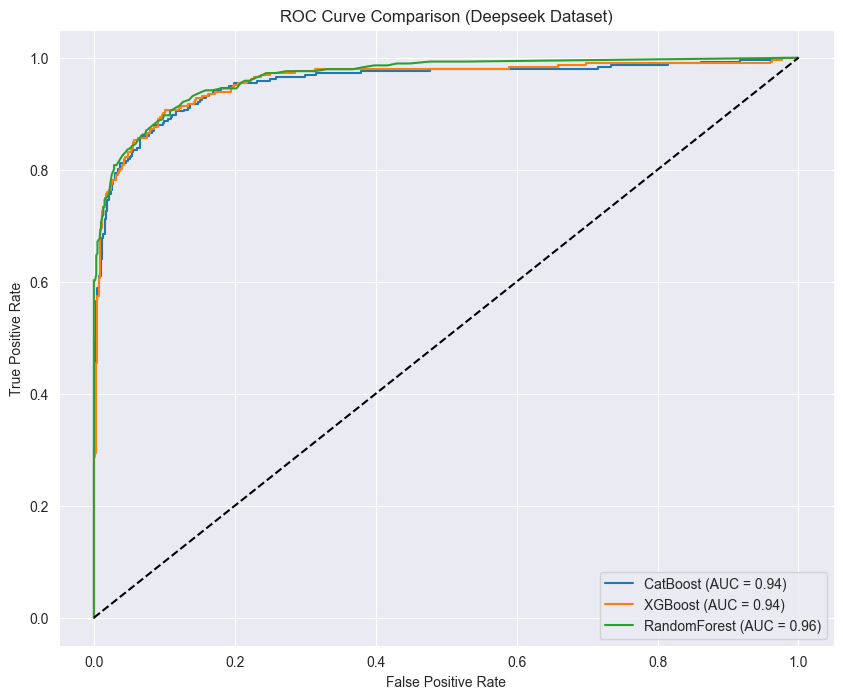

In [36]:
# Plot ROC curves for deepseek dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_deepseek.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Deepseek Dataset)')
plt.legend(loc='lower right')
plt.show()


# Copilot with basic params

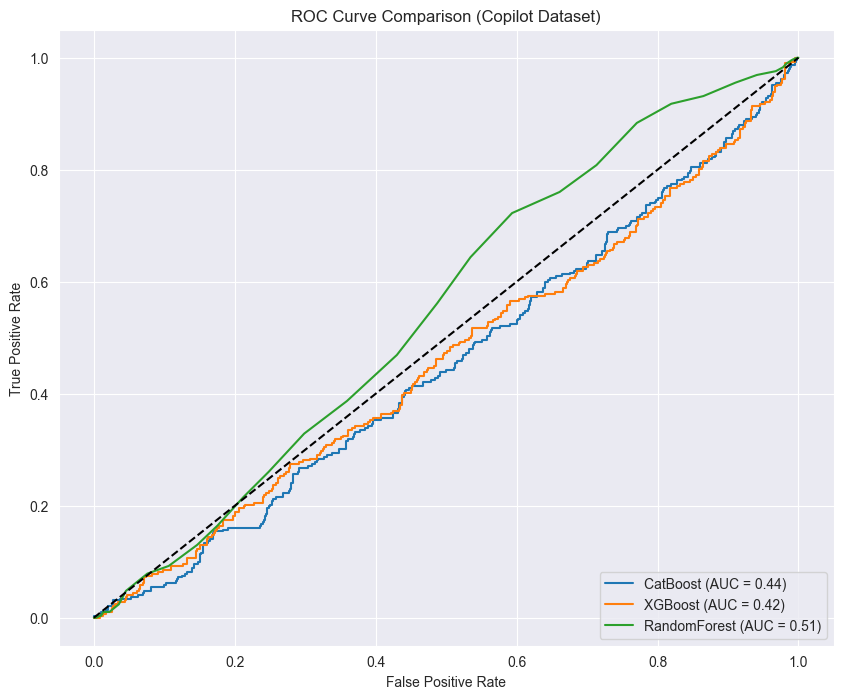

In [37]:
# Plot ROC curves for copilot dataset
plt.figure(figsize=(10, 8))
for model_name, result in results_copilot.items():
    fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Copilot Dataset)')
plt.legend(loc='lower right')
plt.show()

In [38]:
# Print results for deepseek dataset
print("\nResults for Deepseek Dataset:")
for model_name, result in results_deepseek.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Deepseek Dataset:

Model: CatBoost
Accuracy: 0.8520
Precision: 0.8485
Recall: 0.8520
F1-Score: 0.8473
ROC-AUC: 0.9394

Model: XGBoost
Accuracy: 0.8542
Precision: 0.8503
Recall: 0.8542
F1-Score: 0.8501
ROC-AUC: 0.9408

Model: RandomForest
Accuracy: 0.8542
Precision: 0.8529
Recall: 0.8542
F1-Score: 0.8479
ROC-AUC: 0.9560


In [39]:
# Print results for copilot dataset
print("\nResults for Copilot Dataset:")
for model_name, result in results_copilot.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Copilot Dataset:

Model: CatBoost
Accuracy: 0.2893
Precision: 0.3344
Recall: 0.2893
F1-Score: 0.3026
ROC-AUC: 0.4363

Model: XGBoost
Accuracy: 0.2802
Precision: 0.3178
Recall: 0.2802
F1-Score: 0.2925
ROC-AUC: 0.4225

Model: RandomForest
Accuracy: 0.3480
Precision: 0.3866
Recall: 0.3480
F1-Score: 0.3555
ROC-AUC: 0.5067


In [40]:
# Evaluate better models on full dataset
better_results_full = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on full dataset...")
    better_results_full[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

# Evaluate better models on sliced dataset
better_results_sliced = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on sliced dataset...")
    better_results_sliced[better_model_name] = evaluate_model(better_model, X_train_sliced, y_train_sliced, X_test_full, y_test_full)

# Evaluate better models on GPT-generated dataset
better_results_gpt = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on GPT-generated dataset...")
    better_results_gpt[better_model_name] = evaluate_model(better_model, X_train_full, y_train_full, X_test_full, y_test_full)

# Evaluate better models on deepseek dataset
better_results_deepseek = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on deepseek dataset...")
    better_results_deepseek[better_model_name] = evaluate_model(better_model, X_train_deepseek, y_train_deepseek, X_test_full, y_test_full)

# Evaluate better models on copilot dataset
better_results_copilot = {}
for better_model_name, better_model in better_models.items():
    print(f"Training {better_model_name} with better parameters on copilot dataset...")
    better_results_copilot[better_model_name] = evaluate_model(better_model, X_train_copilot, y_train_copilot, X_test_full, y_test_full)

Training CatBoost with better parameters on full dataset...
Training XGBoost with better parameters on full dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest with better parameters on full dataset...
Training CatBoost with better parameters on sliced dataset...
Training XGBoost with better parameters on sliced dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest with better parameters on sliced dataset...
Training CatBoost with better parameters on GPT-generated dataset...
Training XGBoost with better parameters on GPT-generated dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:34:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest with better parameters on GPT-generated dataset...
Training CatBoost with better parameters on deepseek dataset...
Training XGBoost with better parameters on deepseek dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:34:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest with better parameters on deepseek dataset...
Training CatBoost with better parameters on copilot dataset...
Training XGBoost with better parameters on copilot dataset...


D:\LLM_exp\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:34:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training RandomForest with better parameters on copilot dataset...


# All models plotting results

              Dataset         Model  Accuracy  Precision    Recall  F1-Score  \
0            Original      CatBoost  0.750282   0.741858  0.750282  0.744126   
1            Original       XGBoost  0.746893   0.740024  0.746893  0.740659   
2            Original  RandomForest  0.772881   0.765165  0.772881  0.763118   
3              Sliced      CatBoost  0.819209   0.815402  0.819209  0.811709   
4              Sliced       XGBoost  0.824859   0.819459  0.824859  0.820431   
5              Sliced  RandomForest  0.832768   0.829466  0.832768  0.823747   
6                 GPT      CatBoost  0.750282   0.741858  0.750282  0.744126   
7                 GPT       XGBoost  0.746893   0.740024  0.746893  0.740659   
8                 GPT  RandomForest  0.772881   0.765165  0.772881  0.763118   
9            Deepseek      CatBoost  0.851977   0.848503  0.851977  0.847291   
10           Deepseek       XGBoost  0.854237   0.850252  0.854237  0.850098   
11           Deepseek  RandomForest  0.8

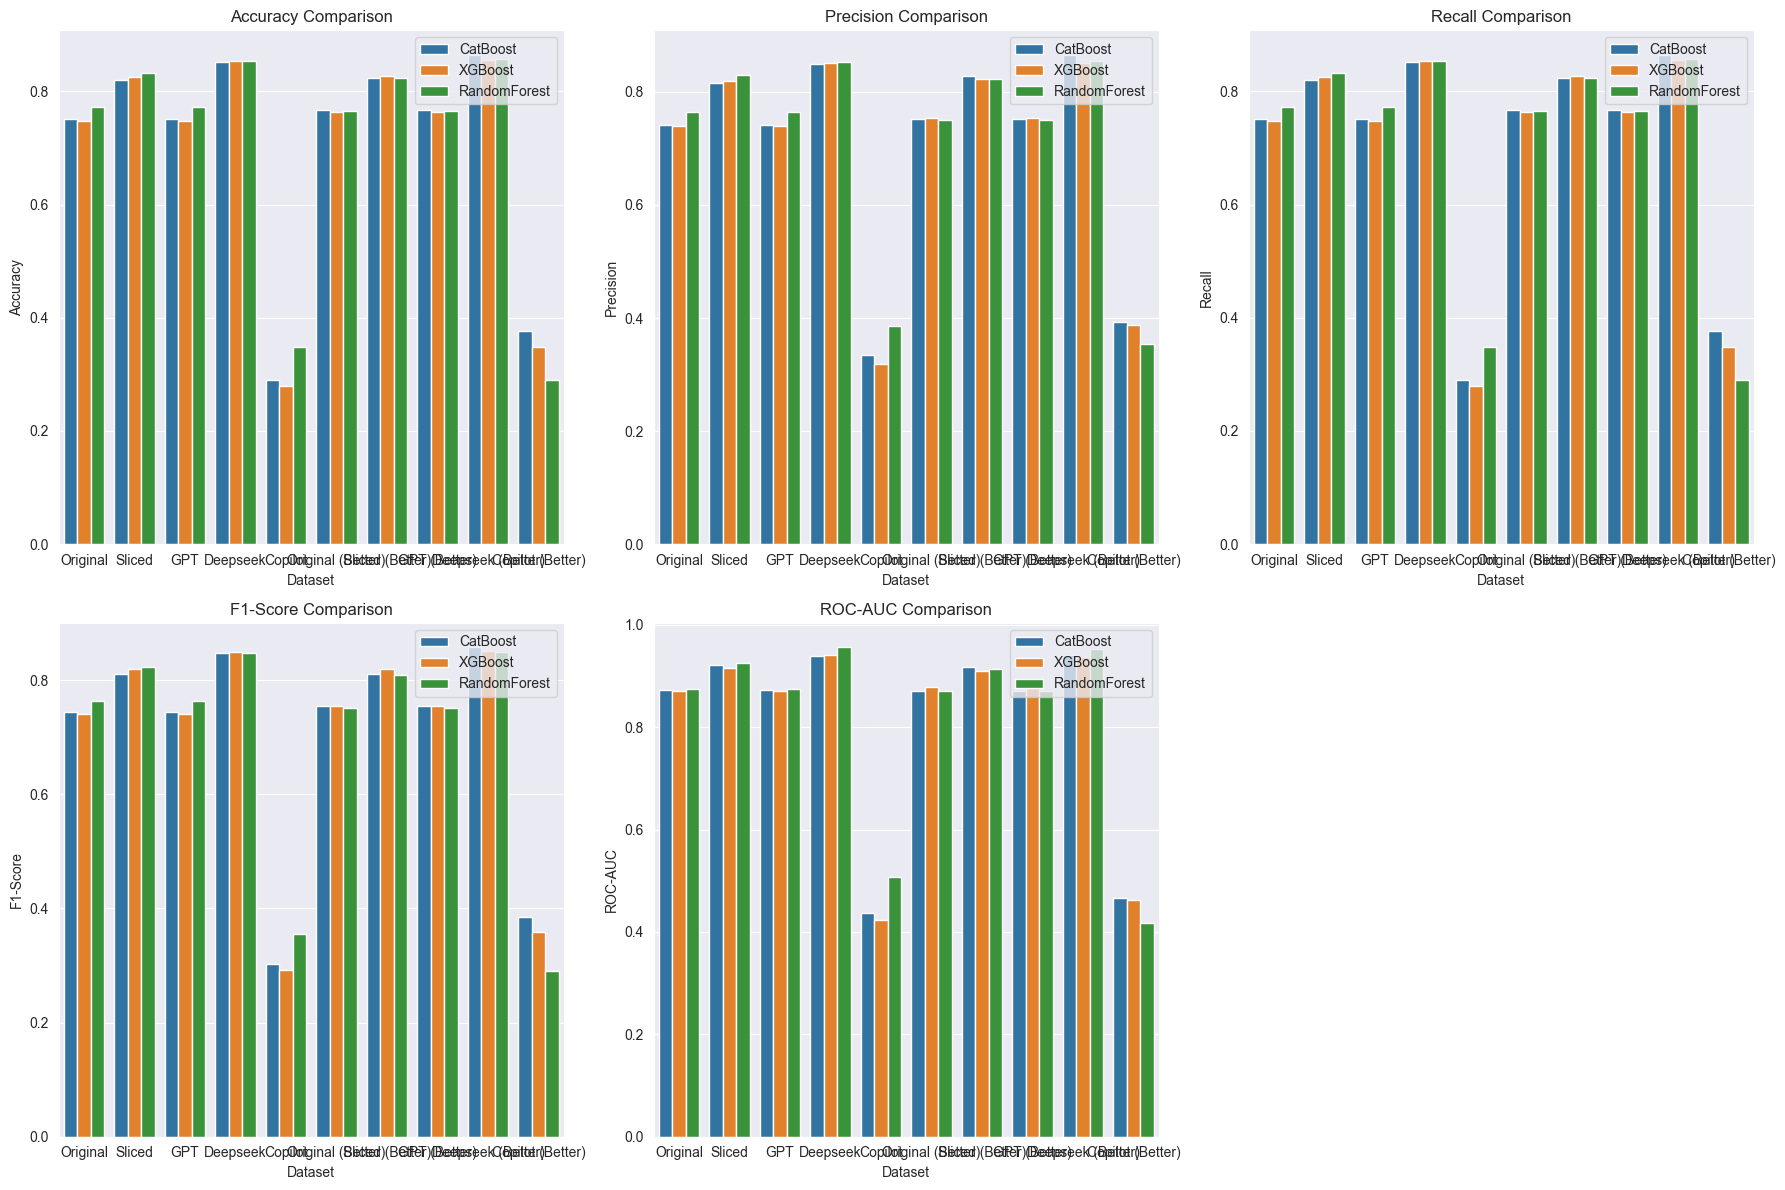

In [41]:
results = {
    'Dataset': [],
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}


for model_name, result in results_full.items():
    results['Dataset'].append('Original')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_sliced.items():
    results['Dataset'].append('Sliced')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in results_gpt.items():
    results['Dataset'].append('GPT')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in results_deepseek.items():
    results['Dataset'].append('Deepseek')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in results_copilot.items():
    results['Dataset'].append('Copilot')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


for model_name, result in better_results_full.items():
    results['Dataset'].append('Original (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_sliced.items():
    results['Dataset'].append('Sliced (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_gpt.items():
    results['Dataset'].append('GPT (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_deepseek.items():
    results['Dataset'].append('Deepseek (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])

for model_name, result in better_results_copilot.items():
    results['Dataset'].append('Copilot (Better)')
    results['Model'].append(model_name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Recall'].append(result['recall'])
    results['F1-Score'].append(result['f1'])
    results['ROC-AUC'].append(result['roc_auc'])


results_df = pd.DataFrame(results)


print(results_df)


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=results_df, x='Dataset', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Plotting basic params models

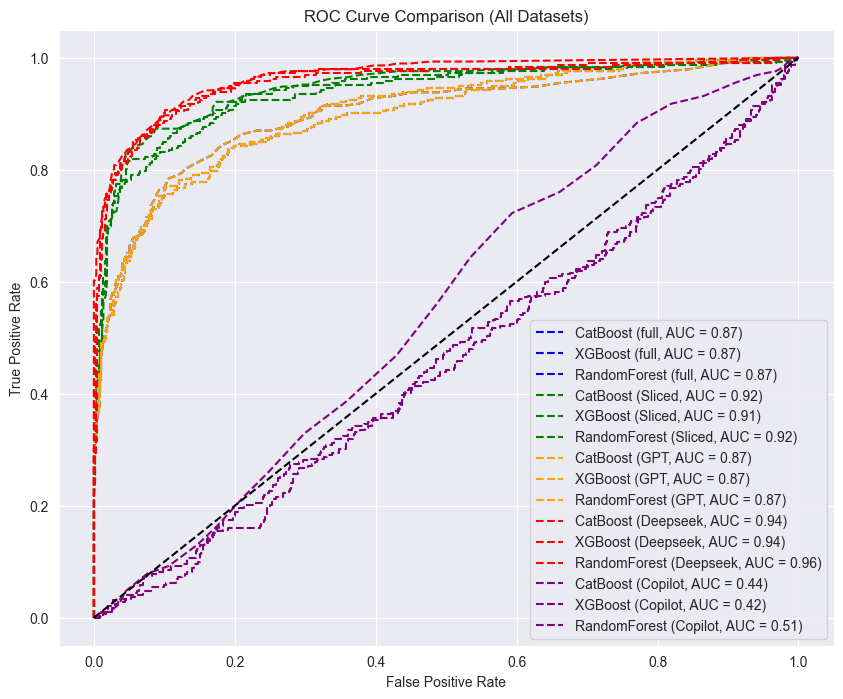

In [42]:
plt.figure(figsize=(10, 8))
for dataset, color in zip(['full', 'Sliced','GPT','Deepseek', 'Copilot'], ['blue', 'green', 'orange','red', 'purple','yellow']):
    for model_name, result in eval(f'results_{dataset.lower()}').items():
        fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f'{model_name} ({dataset}, AUC = {result["roc_auc"]:.2f})', color=color, linestyle='--' if dataset != 'Original' else '-')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (All Datasets)')
plt.legend(loc='lower right')
plt.show()

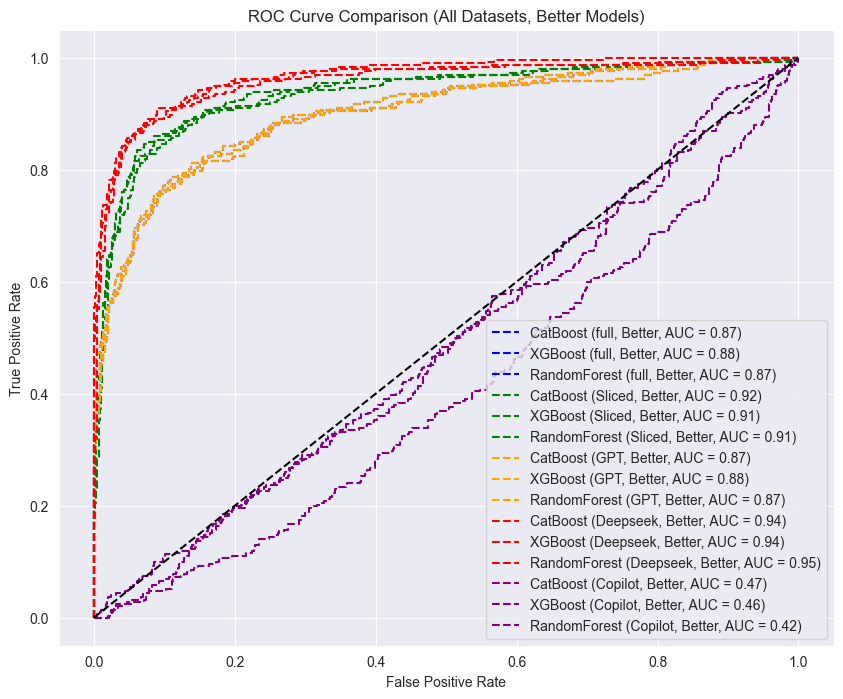

In [43]:
# Plot updated ROC curves
plt.figure(figsize=(10, 8))
for dataset, color in zip(['full', 'Sliced', 'GPT', 'Deepseek', 'Copilot'], ['blue', 'green', 'orange', 'red', 'purple', 'yellow']):
    for model_name, result in eval(f'better_results_{dataset.lower()}').items():
        fpr, tpr, _ = roc_curve(y_test_full, result['y_pred_proba'][:, 1], pos_label=1)
        plt.plot(fpr, tpr, label=f'{model_name} ({dataset}, Better, AUC = {result["roc_auc"]:.2f})', color=color, linestyle='--' if dataset != 'Original' else '-')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (All Datasets, Better Models)')
plt.legend(loc='lower right')
plt.show()

## Result for better params for all datasets

In [44]:
# Print results for better models on full dataset
print("\nResults for Better Models on Full Dataset:")
for model_name, result in better_results_full.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on sliced dataset
print("\nResults for Better Models on Sliced Dataset:")
for model_name, result in better_results_sliced.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on GPT-generated dataset
print("\nResults for Better Models on GPT-Generated Dataset:")
for model_name, result in better_results_gpt.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on deepseek dataset
print("\nResults for Better Models on Deepseek Dataset:")
for model_name, result in better_results_deepseek.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")

# Print results for better models on copilot dataset
print("\nResults for Better Models on Copilot Dataset:")
for model_name, result in better_results_copilot.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-Score: {result['f1']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")


Results for Better Models on Full Dataset:

Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8780

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7507
Recall: 0.7650
F1-Score: 0.7509
ROC-AUC: 0.8702

Results for Better Models on Sliced Dataset:

Model: CatBoost
Accuracy: 0.8237
Precision: 0.8285
Recall: 0.8237
F1-Score: 0.8109
ROC-AUC: 0.9176

Model: XGBoost
Accuracy: 0.8271
Precision: 0.8225
Recall: 0.8271
F1-Score: 0.8190
ROC-AUC: 0.9103

Model: RandomForest
Accuracy: 0.8226
Precision: 0.8232
Recall: 0.8226
F1-Score: 0.8090
ROC-AUC: 0.9131

Results for Better Models on GPT-Generated Dataset:

Model: CatBoost
Accuracy: 0.7661
Precision: 0.7519
Recall: 0.7661
F1-Score: 0.7540
ROC-AUC: 0.8715

Model: XGBoost
Accuracy: 0.7638
Precision: 0.7539
Recall: 0.7638
F1-Score: 0.7542
ROC-AUC: 0.8780

Model: RandomForest
Accuracy: 0.7650
Precision: 0.7

In [45]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,0.680154
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.759359
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,1.000000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,2.000000


In [46]:
df_sliced.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,...,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,1.167421,18.294118,1.683258,8910.115385,0.909502,4.361991,132.630543,1.859729,17.052036,20.789593,...,0.502262,6.192308,7.830317,4.452489,10.400820,0.128959,11.663348,1.067195,-0.061448,0.671946
std,0.609097,17.262398,1.215598,1992.980304,0.287219,9.945895,12.782673,7.011054,14.976308,15.469774,...,1.738257,2.074931,3.618507,2.897142,5.200203,0.570732,2.570735,1.404313,2.269422,0.739909
min,1.000000,1.000000,1.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,1.000000,3.000000,...,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,0.600000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.000000,53.000000,6.000000,9991.000000,1.000000,43.000000,182.000000,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.000000,17.000000,16.666667,5.000000,16.200000,3.700000,3.510000,2.000000


In [47]:
df_copilot.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.173852,18.613888,1.655127,8919.074069,0.918414,4.426148,132.787378,1.819528,16.781310,20.457463,...,0.472006,6.181476,7.857693,4.465942,10.367376,0.148412,11.642783,1.065259,-0.089643,0.994118
std,0.608439,17.368643,1.225082,1979.737197,0.285909,9.938702,12.911496,6.998404,14.915772,15.251961,...,1.703495,2.072593,3.557423,2.975355,5.135706,0.572912,2.584468,1.406589,2.273429,0.813421
min,-1.185167,-42.425776,-2.413566,1677.876012,-0.241898,-31.292537,78.781687,-21.195684,-35.503872,-37.770270,...,-5.791581,-1.440829,-6.390822,-6.718493,-7.619291,-2.013147,2.798074,-3.732118,-7.560862,0.000000
25%,0.764287,6.968266,0.804377,7592.040219,0.732005,-2.511487,124.279149,-2.971893,6.325196,10.019239,...,-0.666076,4.805227,5.512725,2.421149,6.881256,-0.251345,9.875877,0.094768,-1.595090,0.000000
50%,1.170517,18.329000,1.662506,8919.137339,0.916649,4.580770,132.625332,1.915514,17.104869,20.389860,...,0.470011,6.138270,7.857298,4.477476,10.480853,0.150148,11.636793,1.057909,-0.066773,1.000000
75%,1.584281,30.641864,2.449864,10274.149450,1.109411,11.228398,141.511160,6.641228,26.759348,30.601833,...,1.631301,7.577497,10.206416,6.531338,13.831067,0.543630,13.410581,2.033450,1.449860,2.000000
max,3.530976,75.776436,6.114010,15058.647765,1.968890,36.721421,179.331769,30.285219,73.337115,72.957822,...,6.160575,13.045782,18.861200,14.587243,28.127725,2.072884,22.561217,6.330993,8.096796,2.000000


In [48]:
df_gpt = pd.read_csv('D:/LLM_exp/synthetic_dataset.csv')

In [49]:
df_gpt.describe()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.159276,18.476697,1.664706,8887.362443,0.914480,4.460407,132.520360,1.880995,16.869231,20.907692,...,0.488914,6.216063,7.717904,4.505204,10.438599,0.130543,11.707489,1.060271,-0.107265,0.676471
std,0.583369,17.313390,1.201859,2048.238672,0.279686,10.134578,12.792340,6.866776,15.006285,15.362883,...,1.717056,2.053960,3.650836,2.816918,5.235437,0.577875,2.578125,1.417859,2.272290,0.742063
min,1.000000,1.000000,1.000000,33.000000,0.000000,1.000000,86.160710,1.000000,1.000000,1.000000,...,0.000000,0.000000,-6.857544,0.000000,-6.574867,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,124.052609,1.000000,1.000000,3.000000,...,0.000000,5.000000,5.265149,3.000000,6.925985,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,132.486810,1.000000,19.000000,19.000000,...,0.000000,6.000000,7.740342,5.000000,10.401450,0.000000,11.100000,0.600000,0.320000,1.000000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,141.359255,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.210165,6.000000,14.005395,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.000000,53.000000,6.000000,9991.000000,1.000000,43.000000,180.668433,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.520884,17.000000,28.998620,5.000000,16.200000,3.700000,3.510000,2.000000


In [50]:
df_deepseek.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target_encoded
count,4420.00000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,...,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000,4420.000000
mean,1.16448,18.475566,1.678733,8904.322172,0.906561,4.226697,132.605950,1.908371,17.027602,20.987104,...,0.509502,6.216742,7.849095,4.458597,10.362661,0.112443,11.675430,1.051063,-0.039975,0.671493
std,0.60124,17.219641,1.192475,1994.725645,0.291079,9.629935,12.564195,7.238164,14.840242,15.392932,...,1.745689,2.089552,3.664424,2.917801,5.238082,0.521351,2.565153,1.400636,2.254784,0.739872
min,1.00000,1.000000,1.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.00000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,1.000000,3.000000,...,0.000000,5.000000,6.000000,3.000000,10.842857,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.00000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,0.600000,0.320000,1.000000
75%,1.00000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000,1.000000
max,5.00000,53.000000,6.000000,9991.000000,1.000000,43.000000,182.000000,105.000000,40.000000,40.000000,...,14.000000,17.000000,20.000000,17.000000,16.666667,5.000000,16.200000,3.700000,3.510000,2.000000


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

# KL Divergence test

In [52]:
def calculate_kl_divergence(dataset1, dataset2, bins=50):
    """
    Calculate KL divergence between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.
        bins (int): Number of bins for histogram.

    Returns:
        dict: Feature-wise KL divergence values.
    """
    kl_divergences = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                hist1, bin_edges = np.histogram(dataset1[column], bins=bins, density=True)
                hist2, _ = np.histogram(dataset2[column], bins=bin_edges, density=True)

                # Avoid division by zero by adding a small value (epsilon)
                epsilon = 1e-10
                hist1 += epsilon
                hist2 += epsilon

                # Normalize histograms
                hist1 /= np.sum(hist1)
                hist2 /= np.sum(hist2)

                kl_divergences[column] = entropy(hist1, hist2)
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return kl_divergences

In [53]:
# Example usage with existing datasets
# Assuming datasets are named df_train and df_synthetic
kl_results_gpt = calculate_kl_divergence(df, df_gpt)


# Display KL divergence results
print("KL Divergence results for GPT (feature-wise):")
for feature, kl_value in kl_results_gpt.items():
    print(f"{feature}: {kl_value:.4f}")


mean_kl_divergence = np.mean(list(kl_results_gpt.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")

KL Divergence results for GPT (feature-wise):
Application mode: 0.0197
Application order: 0.0151
Course: 0.0094
Previous qualification: 0.0360
Previous qualification (grade): 0.3084
Nacionality: 0.0722
Mother's qualification: 0.1632
Father's qualification: 0.1373
Mother's occupation: 0.1139
Father's occupation: 0.1885
Admission grade: 0.1311
Displaced: 0.0000
Educational special needs: 0.0008
Debtor: 0.0001
Tuition fees up to date: 0.0000
Gender: 0.0021
Scholarship holder: 0.0000
Age at enrollment: 0.9439
International: 0.0008
Curricular units 1st sem (credited): 0.1657
Curricular units 1st sem (enrolled): 0.0974
Curricular units 1st sem (evaluations): 0.4932
Curricular units 1st sem (approved): 0.3137
Curricular units 1st sem (grade): 1.2020
Curricular units 1st sem (without evaluations): 0.0733
Curricular units 2nd sem (credited): 0.1459
Curricular units 2nd sem (enrolled): 0.0541
Curricular units 2nd sem (evaluations): 0.8159
Curricular units 2nd sem (approved): 0.0515
Curricular un

In [54]:
kl_results_deepseek = calculate_kl_divergence(df, df_deepseek)
print("KL Divergence results for Deepseek (feature-wise):")
for feature, kl_value in kl_results_deepseek.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_deepseek.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Deepseek (feature-wise):
Marital status: 0.0421
Application mode: 0.0196
Application order: 0.0161
Course: 0.0074
Daytime/evening attendance	: 0.0014
Previous qualification: 0.0327
Previous qualification (grade): 0.2609
Nacionality: 0.0730
Mother's qualification: 0.1627
Father's qualification: 0.1308
Mother's occupation: 0.1125
Father's occupation: 0.1929
Admission grade: 0.2353
Displaced: 0.0000
Educational special needs: 0.0015
Debtor: 0.0001
Tuition fees up to date: 0.0000
Gender: 0.0015
Scholarship holder: 0.0000
Age at enrollment: 0.2592
International: 0.0000
Curricular units 1st sem (credited): 0.1652
Curricular units 1st sem (enrolled): 0.0927
Curricular units 1st sem (evaluations): 0.1173
Curricular units 1st sem (approved): 0.3167
Curricular units 1st sem (grade): 0.0374
Curricular units 1st sem (without evaluations): 0.0743
Curricular units 2nd sem (credited): 0.1431
Curricular units 2nd sem (enrolled): 0.0537
Curricular units 2nd sem (evaluations): 

In [55]:
kl_results_copilot = calculate_kl_divergence(df, df_copilot)
print("KL Divergence results for Copilot (feature-wise):")
for feature, kl_value in kl_results_copilot.items():
    print(f"{feature}: {kl_value:.4f}")



    mean_kl_divergence = np.mean(list(kl_results_copilot.values()))
print(f"\nMean KL Divergence: {mean_kl_divergence:.4f}")


KL Divergence results for Copilot (feature-wise):
Marital status: 2.6133
Application mode: 2.0786
Application order: 2.2156
Course: 1.9116
Daytime/evening attendance	: 5.4476
Previous qualification: 3.6243
Previous qualification (grade): 0.2566
Nacionality: 1.6641
Mother's qualification: 2.1981
Father's qualification: 2.2798
Mother's occupation: 1.7932
Father's occupation: 1.7152
Admission grade: 0.1295
Displaced: 3.8069
Educational special needs: 1.9194
Debtor: 3.3636
Tuition fees up to date: 3.4201
Gender: 3.6216
Scholarship holder: 3.4468
Age at enrollment: 0.8937
International: 2.7689
Curricular units 1st sem (credited): 2.1244
Curricular units 1st sem (enrolled): 1.3828
Curricular units 1st sem (evaluations): 0.4492
Curricular units 1st sem (approved): 1.0291
Curricular units 1st sem (grade): 1.2034
Curricular units 1st sem (without evaluations): 1.3322
Curricular units 2nd sem (credited): 1.9661
Curricular units 2nd sem (enrolled): 1.3895
Curricular units 2nd sem (evaluations): 0

# JS Divergence

In [56]:
def calculate_js_divergence(dataset1, dataset2, bins=50):
    """
    Calculate Jensen-Shannon divergence between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.
        bins (int): Number of bins for histogram.

    Returns:
        dict: Feature-wise Jensen-Shannon divergence values.
    """
    js_divergences = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                hist1, bin_edges = np.histogram(dataset1[column], bins=bins, density=True)
                hist2, _ = np.histogram(dataset2[column], bins=bin_edges, density=True)

                # Avoid division by zero by adding a small value (epsilon)
                epsilon = 1e-10
                hist1 += epsilon
                hist2 += epsilon

                # Normalize histograms
                hist1 /= np.sum(hist1)
                hist2 /= np.sum(hist2)

                # Calculate the midpoint distribution
                midpoint = 0.5 * (hist1 + hist2)

                # Calculate Jensen-Shannon divergence
                js_divergence = 0.5 * (entropy(hist1, midpoint) + entropy(hist2, midpoint))
                js_divergences[column] = js_divergence
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return js_divergences

In [57]:
js_results_gpt = calculate_js_divergence(df, df_gpt)



print("\nDistribution Overlap results (feature-wise):")
for feature, overlap in js_results_gpt.items():
    print(f"{feature}: {overlap:.4f}")

mean_overlap = np.mean(list(js_results_gpt.values()))
print(f"\nMean Distribution Overlap: {mean_overlap:.4f}")


Distribution Overlap results (feature-wise):
Application mode: 0.0025
Application order: 0.0019
Course: 0.0023
Previous qualification: 0.0029
Previous qualification (grade): 0.0583
Nacionality: 0.0028
Mother's qualification: 0.0104
Father's qualification: 0.0082
Mother's occupation: 0.0041
Father's occupation: 0.0062
Admission grade: 0.0202
Displaced: 0.0000
Educational special needs: 0.0002
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0005
Scholarship holder: 0.0000
Age at enrollment: 0.1291
International: 0.0002
Curricular units 1st sem (credited): 0.0051
Curricular units 1st sem (enrolled): 0.0045
Curricular units 1st sem (evaluations): 0.1072
Curricular units 1st sem (approved): 0.0095
Curricular units 1st sem (grade): 0.2638
Curricular units 1st sem (without evaluations): 0.0020
Curricular units 2nd sem (credited): 0.0047
Curricular units 2nd sem (enrolled): 0.0026
Curricular units 2nd sem (evaluations): 0.1986
Curricular units 2nd sem (approved): 0.0055
Curricular un

In [58]:
js_results_deepseek = calculate_js_divergence(df, df_deepseek)




print("\nJensen-Shannon Divergence results (feature-wise):")
for feature, js_value in js_results_deepseek.items():
    print(f"{feature}: {js_value:.4f}")

mean_js_divergence = np.mean(list(js_results_deepseek.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results (feature-wise):
Marital status: 0.0014
Application mode: 0.0027
Application order: 0.0022
Course: 0.0018
Daytime/evening attendance	: 0.0003
Previous qualification: 0.0020
Previous qualification (grade): 0.0129
Nacionality: 0.0030
Mother's qualification: 0.0103
Father's qualification: 0.0067
Mother's occupation: 0.0039
Father's occupation: 0.0070
Admission grade: 0.0148
Displaced: 0.0000
Educational special needs: 0.0003
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0004
Scholarship holder: 0.0000
Age at enrollment: 0.0114
International: 0.0000
Curricular units 1st sem (credited): 0.0050
Curricular units 1st sem (enrolled): 0.0038
Curricular units 1st sem (evaluations): 0.0069
Curricular units 1st sem (approved): 0.0104
Curricular units 1st sem (grade): 0.0062
Curricular units 1st sem (without evaluations): 0.0024
Curricular units 2nd sem (credited): 0.0043
Curricular units 2nd sem (enrolled): 0.0025
Curricular units 2nd sem (evaluations): 

In [59]:
js_results_copilot = calculate_js_divergence(df, df_copilot)



print("\nJensen-Shannon Divergence results (feature-wise):")
for feature, js_value in js_results_copilot.items():
    print(f"{feature}: {js_value:.4f}")

mean_js_divergence = np.mean(list(js_results_copilot.values()))
print(f"\nMean Jensen-Shannon Divergence: {mean_js_divergence:.4f}")


Jensen-Shannon Divergence results (feature-wise):
Marital status: 0.4945
Application mode: 0.4546
Application order: 0.4819
Course: 0.3484
Daytime/evening attendance	: 0.6095
Previous qualification: 0.5067
Previous qualification (grade): 0.0569
Nacionality: 0.3965
Mother's qualification: 0.4672
Father's qualification: 0.4777
Mother's occupation: 0.3438
Father's occupation: 0.3317
Admission grade: 0.0203
Displaced: 0.6395
Educational special needs: 0.4381
Debtor: 0.6114
Tuition fees up to date: 0.6145
Gender: 0.6312
Scholarship holder: 0.6205
Age at enrollment: 0.1255
International: 0.5231
Curricular units 1st sem (credited): 0.4164
Curricular units 1st sem (enrolled): 0.3101
Curricular units 1st sem (evaluations): 0.1045
Curricular units 1st sem (approved): 0.2449
Curricular units 1st sem (grade): 0.2644
Curricular units 1st sem (without evaluations): 0.3101
Curricular units 2nd sem (credited): 0.3873
Curricular units 2nd sem (enrolled): 0.3250
Curricular units 2nd sem (evaluations): 

# Wasserstien Distance

In [61]:
# Function to calculate Earth Mover's Distance (Wasserstein Distance)
def calculate_wasserstein_distance(dataset1, dataset2):
    """
    Calculate Wasserstein Distance between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.

    Returns:
        dict: Feature-wise Wasserstein Distance values.
    """
    wasserstein_distances = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                wasserstein_distances[column] = wasserstein_distance(dataset1[column], dataset2[column])
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return wasserstein_distances

In [62]:
wasserstein_results_gpt = calculate_wasserstein_distance(df, df_gpt)

print("\nWasserstein Distance results (feature-wise):")
for feature, wd_value in wasserstein_results_gpt.items():
    print(f"{feature}: {wd_value:.4f}")


Wasserstein Distance results (feature-wise):
Application mode: 0.1997
Application order: 0.0636
Course: 35.8845
Previous qualification: 0.1246
Previous qualification (grade): 1.3711
Nacionality: 0.1552
Mother's qualification: 2.6936
Father's qualification: 1.3806
Mother's occupation: 2.3155
Father's occupation: 1.7420
Admission grade: 1.3634
Displaced: 0.0024
Educational special needs: 0.0038
Debtor: 0.0055
Tuition fees up to date: 0.0008
Gender: 0.0315
Scholarship holder: 0.0002
Age at enrollment: 3.2871
International: 0.0056
Curricular units 1st sem (credited): 0.0577
Curricular units 1st sem (enrolled): 0.1123
Curricular units 1st sem (evaluations): 0.9206
Curricular units 1st sem (approved): 0.1718
Curricular units 1st sem (grade): 2.2953
Curricular units 1st sem (without evaluations): 0.0261
Curricular units 2nd sem (credited): 0.0563
Curricular units 2nd sem (enrolled): 0.0746
Curricular units 2nd sem (evaluations): 0.7542
Curricular units 2nd sem (approved): 0.2163
Curricular u

In [63]:
wasserstein_results_deepseek = calculate_wasserstein_distance(df, df_deepseek)

print("\nWasserstein Distance results (feature-wise):")
for feature, wd_value in wasserstein_results_deepseek.items():
    print(f"{feature}: {wd_value:.4f}")


Wasserstein Distance results (feature-wise):
Marital status: 0.0201
Application mode: 0.2848
Application order: 0.0628
Course: 53.9759
Daytime/evening attendance	: 0.0157
Previous qualification: 0.3542
Previous qualification (grade): 0.7666
Nacionality: 0.1468
Mother's qualification: 2.5348
Father's qualification: 1.2986
Mother's occupation: 1.5101
Father's occupation: 1.8004
Admission grade: 0.8801
Displaced: 0.0048
Educational special needs: 0.0050
Debtor: 0.0053
Tuition fees up to date: 0.0010
Gender: 0.0263
Scholarship holder: 0.0020
Age at enrollment: 0.3558
International: 0.0011
Curricular units 1st sem (credited): 0.0564
Curricular units 1st sem (enrolled): 0.0942
Curricular units 1st sem (evaluations): 0.1390
Curricular units 1st sem (approved): 0.1674
Curricular units 1st sem (grade): 0.2328
Curricular units 1st sem (without evaluations): 0.0268
Curricular units 2nd sem (credited): 0.0464
Curricular units 2nd sem (enrolled): 0.0670
Curricular units 2nd sem (evaluations): 0.21

In [64]:
wasserstein_results_copilot = calculate_wasserstein_distance(df, df_copilot)

print("\nWasserstein Distance results (feature-wise):")
for feature, wd_value in wasserstein_results_copilot.items():
    print(f"{feature}: {wd_value:.4f}")


Wasserstein Distance results (feature-wise):
Marital status: 0.4243
Application mode: 6.1984
Application order: 0.6671
Course: 1327.3042
Daytime/evening attendance	: 0.2217
Previous qualification: 7.2680
Previous qualification (grade): 1.3718
Nacionality: 5.7486
Mother's qualification: 6.0249
Father's qualification: 5.9660
Mother's occupation: 16.4155
Father's occupation: 14.9955
Admission grade: 1.3381
Displaced: 0.2701
Educational special needs: 0.0723
Debtor: 0.2359
Tuition fees up to date: 0.2380
Gender: 0.2713
Scholarship holder: 0.2610
Age at enrollment: 3.1744
International: 0.1262
Curricular units 1st sem (credited): 1.6489
Curricular units 1st sem (enrolled): 1.0842
Curricular units 1st sem (evaluations): 0.8681
Curricular units 1st sem (approved): 0.7606
Curricular units 1st sem (grade): 2.2948
Curricular units 1st sem (without evaluations): 0.4312
Curricular units 2nd sem (credited): 1.2686
Curricular units 2nd sem (enrolled): 0.7604
Curricular units 2nd sem (evaluations): 

# Kolmogorov-Svirnov Test

In [65]:
# Function to perform Kolmogorov-Smirnov Test
def kolmogorov_smirnov_test(dataset1, dataset2):
    """
    Perform Kolmogorov-Smirnov Test between two datasets.

    Args:
        dataset1 (pd.DataFrame): First dataset.
        dataset2 (pd.DataFrame): Second dataset.

    Returns:
        dict: Feature-wise p-values from KS Test.
    """
    ks_results = {}

    for column in dataset1.columns:
        if column in dataset2.columns:
            if dataset1[column].dtype in [np.float64, np.int64]:  # Numerical columns only
                _, p_value = ks_2samp(dataset1[column], dataset2[column])
                ks_results[column] = p_value
        else:
            print(f"Warning: Column '{column}' is not present in both datasets.")

    return ks_results

In [71]:
ks_results_gpt = kolmogorov_smirnov_test(df, df_gpt)

print("\nKolmogorov-Smirnov Test p-values (feature-wise):")
for feature, p_value in ks_results_gpt.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_gpt.values()))}")


Kolmogorov-Smirnov Test p-values (feature-wise):
Application mode: 0.4331
Application order: 0.5241
Course: 0.1685
Previous qualification: 0.9808
Previous qualification (grade): 0.0000
Nacionality: 1.0000
Mother's qualification: 0.0000
Father's qualification: 0.0000
Mother's occupation: 0.0059
Father's occupation: 0.0018
Admission grade: 0.0000
Displaced: 1.0000
Educational special needs: 1.0000
Debtor: 1.0000
Tuition fees up to date: 1.0000
Gender: 0.0238
Scholarship holder: 1.0000
Age at enrollment: 0.0000
International: 1.0000
Curricular units 1st sem (credited): 0.9991
Curricular units 1st sem (enrolled): 0.8755
Curricular units 1st sem (evaluations): 0.0000
Curricular units 1st sem (approved): 0.1376
Curricular units 1st sem (grade): 0.0000
Curricular units 1st sem (without evaluations): 1.0000
Curricular units 2nd sem (credited): 0.9902
Curricular units 2nd sem (enrolled): 0.9876
Curricular units 2nd sem (evaluations): 0.0000
Curricular units 2nd sem (approved): 0.0001
Curricula

In [72]:
ks_results_deepseek = kolmogorov_smirnov_test(df, df_deepseek)

print("\nKolmogorov-Smirnov Test p-values (feature-wise):")
for feature, p_value in ks_results_deepseek.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_deepseek.values()))}")


Kolmogorov-Smirnov Test p-values (feature-wise):
Marital status: 0.6354
Application mode: 0.1363
Application order: 0.3982
Course: 0.4462
Daytime/evening attendance	: 0.6351
Previous qualification: 0.9196
Previous qualification (grade): 0.0177
Nacionality: 1.0000
Mother's qualification: 0.0000
Father's qualification: 0.0001
Mother's occupation: 0.0332
Father's occupation: 0.0465
Admission grade: 0.0000
Displaced: 1.0000
Educational special needs: 1.0000
Debtor: 1.0000
Tuition fees up to date: 1.0000
Gender: 0.0907
Scholarship holder: 1.0000
Age at enrollment: 0.0611
International: 1.0000
Curricular units 1st sem (credited): 0.9989
Curricular units 1st sem (enrolled): 0.8616
Curricular units 1st sem (evaluations): 0.2190
Curricular units 1st sem (approved): 0.1750
Curricular units 1st sem (grade): 0.0002
Curricular units 1st sem (without evaluations): 0.9996
Curricular units 2nd sem (credited): 0.9996
Curricular units 2nd sem (enrolled): 0.9519
Curricular units 2nd sem (evaluations): 0

In [73]:
ks_results_copilot = kolmogorov_smirnov_test(df, df_copilot)

print("\nKolmogorov-Smirnov Test p-values (feature-wise):")
for feature, p_value in ks_results_copilot.items():
    print(f"{feature}: {p_value:.4f}")

print(f"\n Mean value :{np.mean(list(ks_results_copilot.values()))}")


Kolmogorov-Smirnov Test p-values (feature-wise):
Marital status: 0.0000
Application mode: 0.0000
Application order: 0.0000
Course: 0.0000
Daytime/evening attendance	: 0.0000
Previous qualification: 0.0000
Previous qualification (grade): 0.0000
Nacionality: 0.0000
Mother's qualification: 0.0000
Father's qualification: 0.0000
Mother's occupation: 0.0000
Father's occupation: 0.0000
Admission grade: 0.0000
Displaced: 0.0000
Educational special needs: 0.0000
Debtor: 0.0000
Tuition fees up to date: 0.0000
Gender: 0.0000
Scholarship holder: 0.0000
Age at enrollment: 0.0000
International: 0.0000
Curricular units 1st sem (credited): 0.0000
Curricular units 1st sem (enrolled): 0.0000
Curricular units 1st sem (evaluations): 0.0000
Curricular units 1st sem (approved): 0.0000
Curricular units 1st sem (grade): 0.0000
Curricular units 1st sem (without evaluations): 0.0000
Curricular units 2nd sem (credited): 0.0000
Curricular units 2nd sem (enrolled): 0.0000
Curricular units 2nd sem (evaluations): 0

# Correlation matrices

In [88]:
# Function to compare correlation matrices
def compare_correlation_matrices(real_data, synthetic_data):
    """
    Compare correlation matrices for real and synthetic datasets.

    Args:
        real_data (pd.DataFrame): Real dataset.
        synthetic_data (pd.DataFrame): Synthetic dataset.
    """
    real_corr = real_data.corr()
    synthetic_corr = synthetic_data.corr()

    plt.figure(figsize=(30, 15))

    # Real dataset heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(real_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Real Data Correlation")

    # Synthetic dataset heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(synthetic_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Synthetic Data Correlation")

    plt.tight_layout()
    plt.show()

# Original VS GPT's datasets

D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


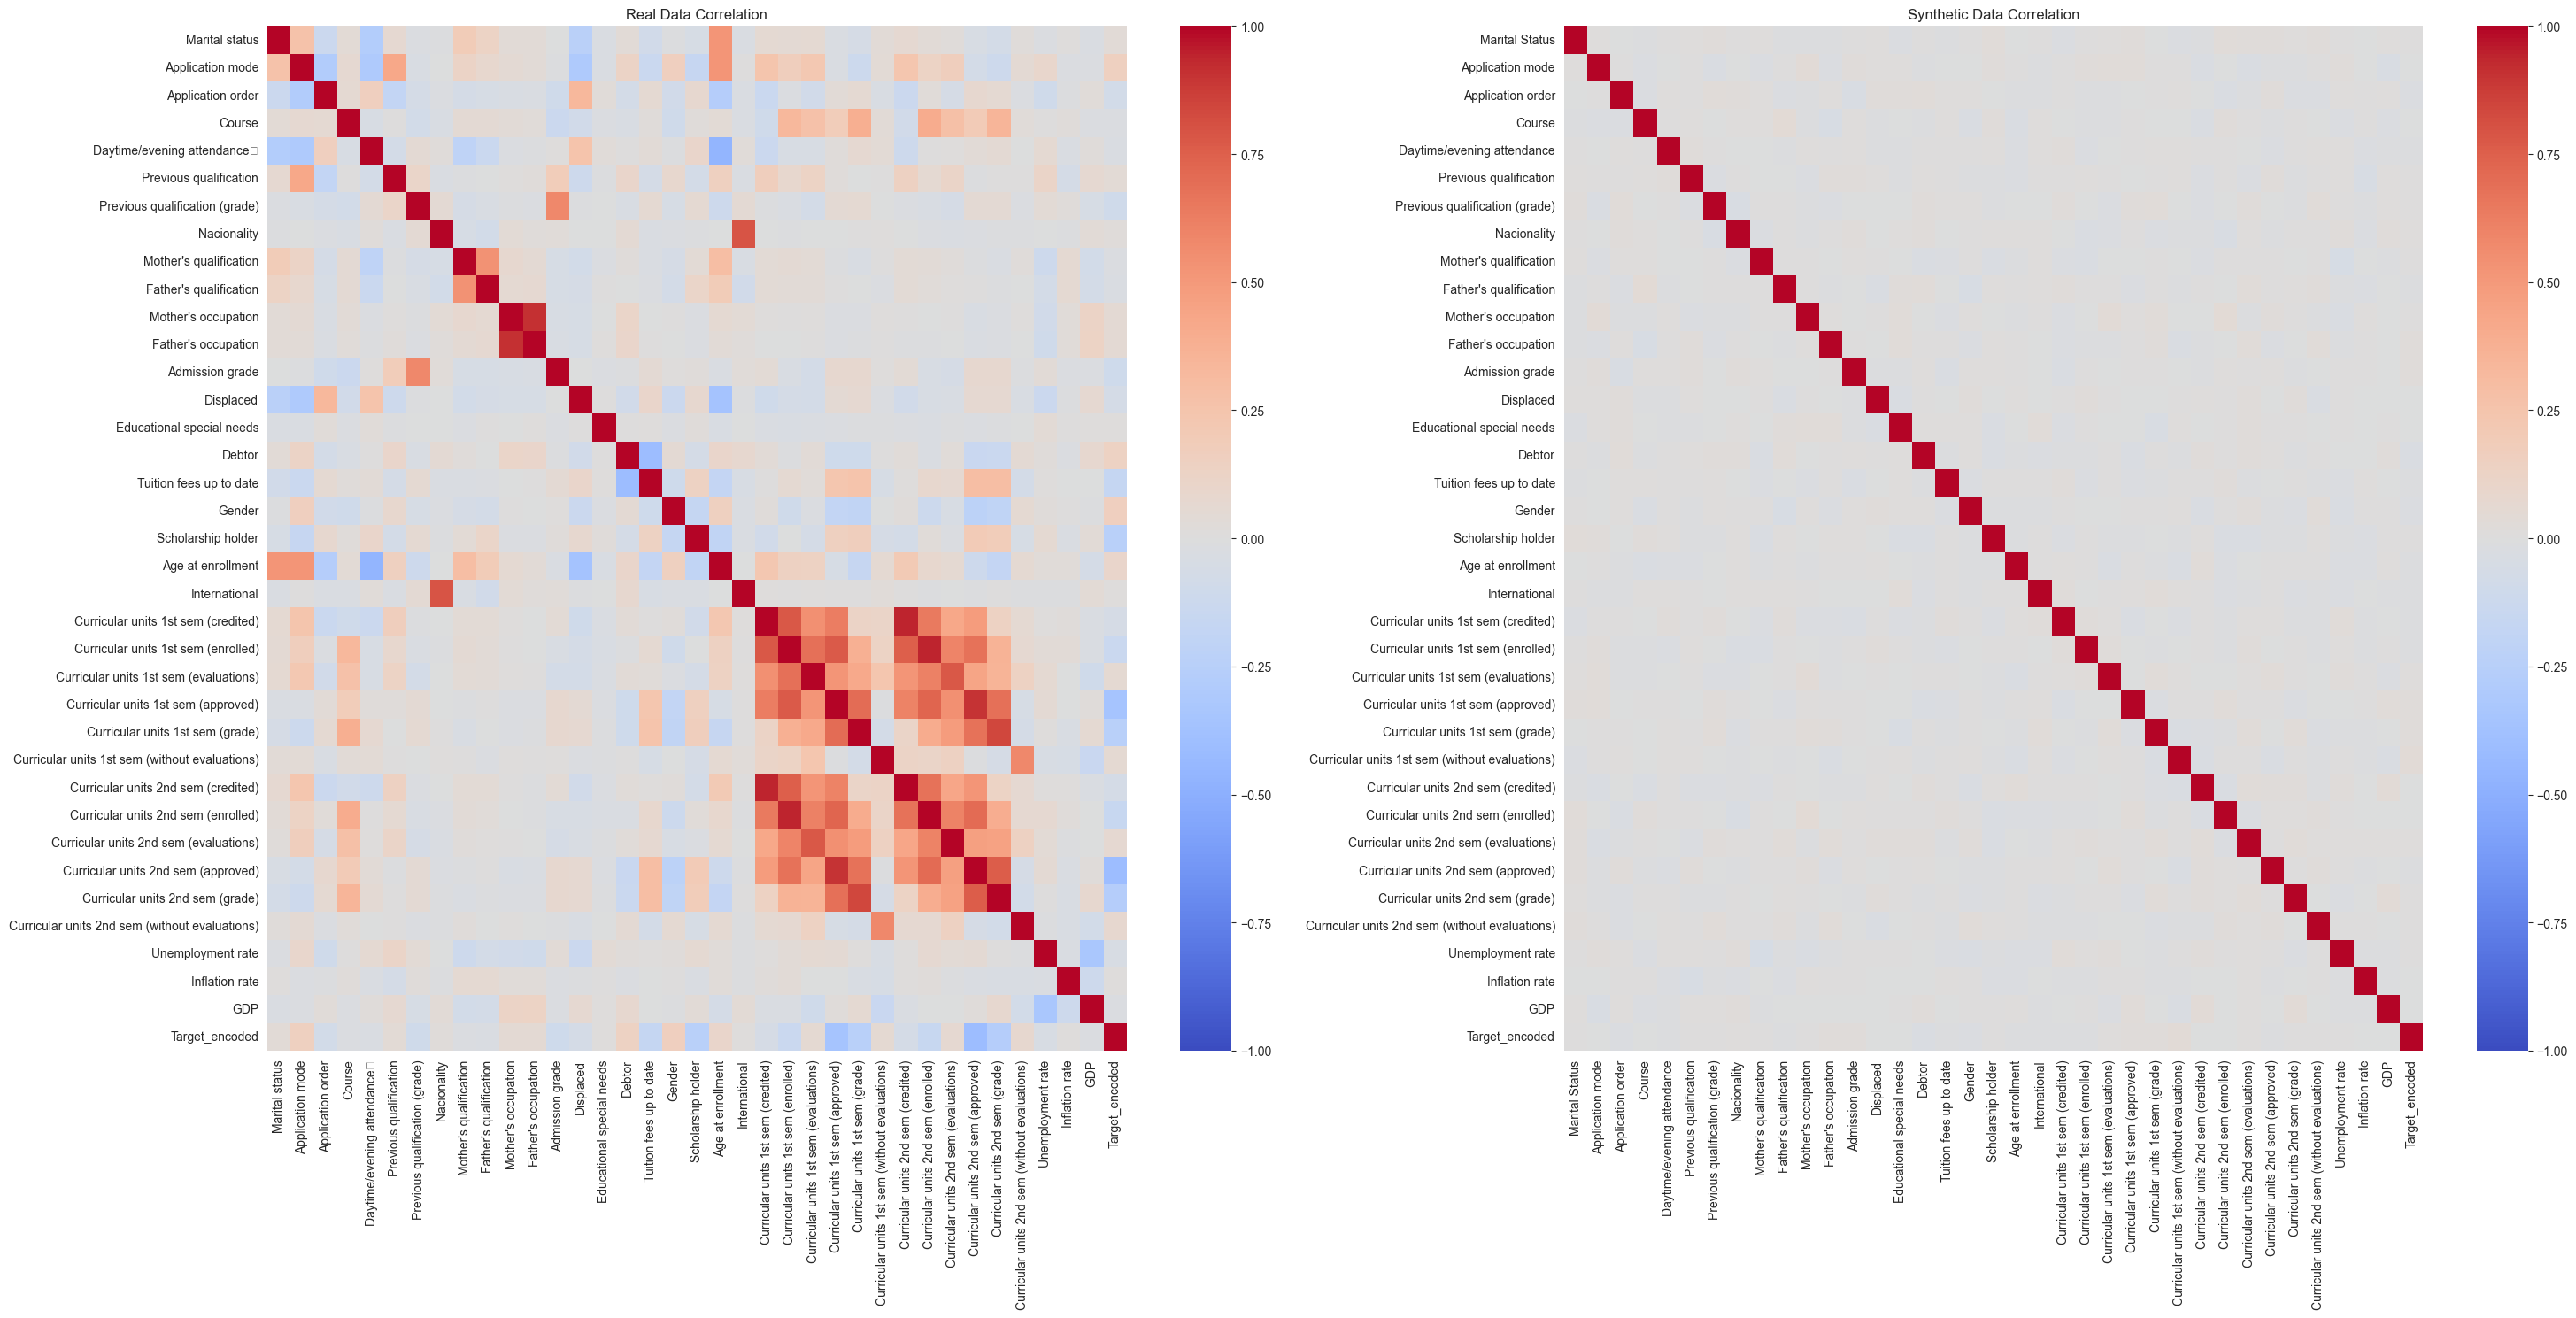

In [89]:
compare_correlation_matrices(df, df_gpt)

# Original VS Deepseek's datasets

D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


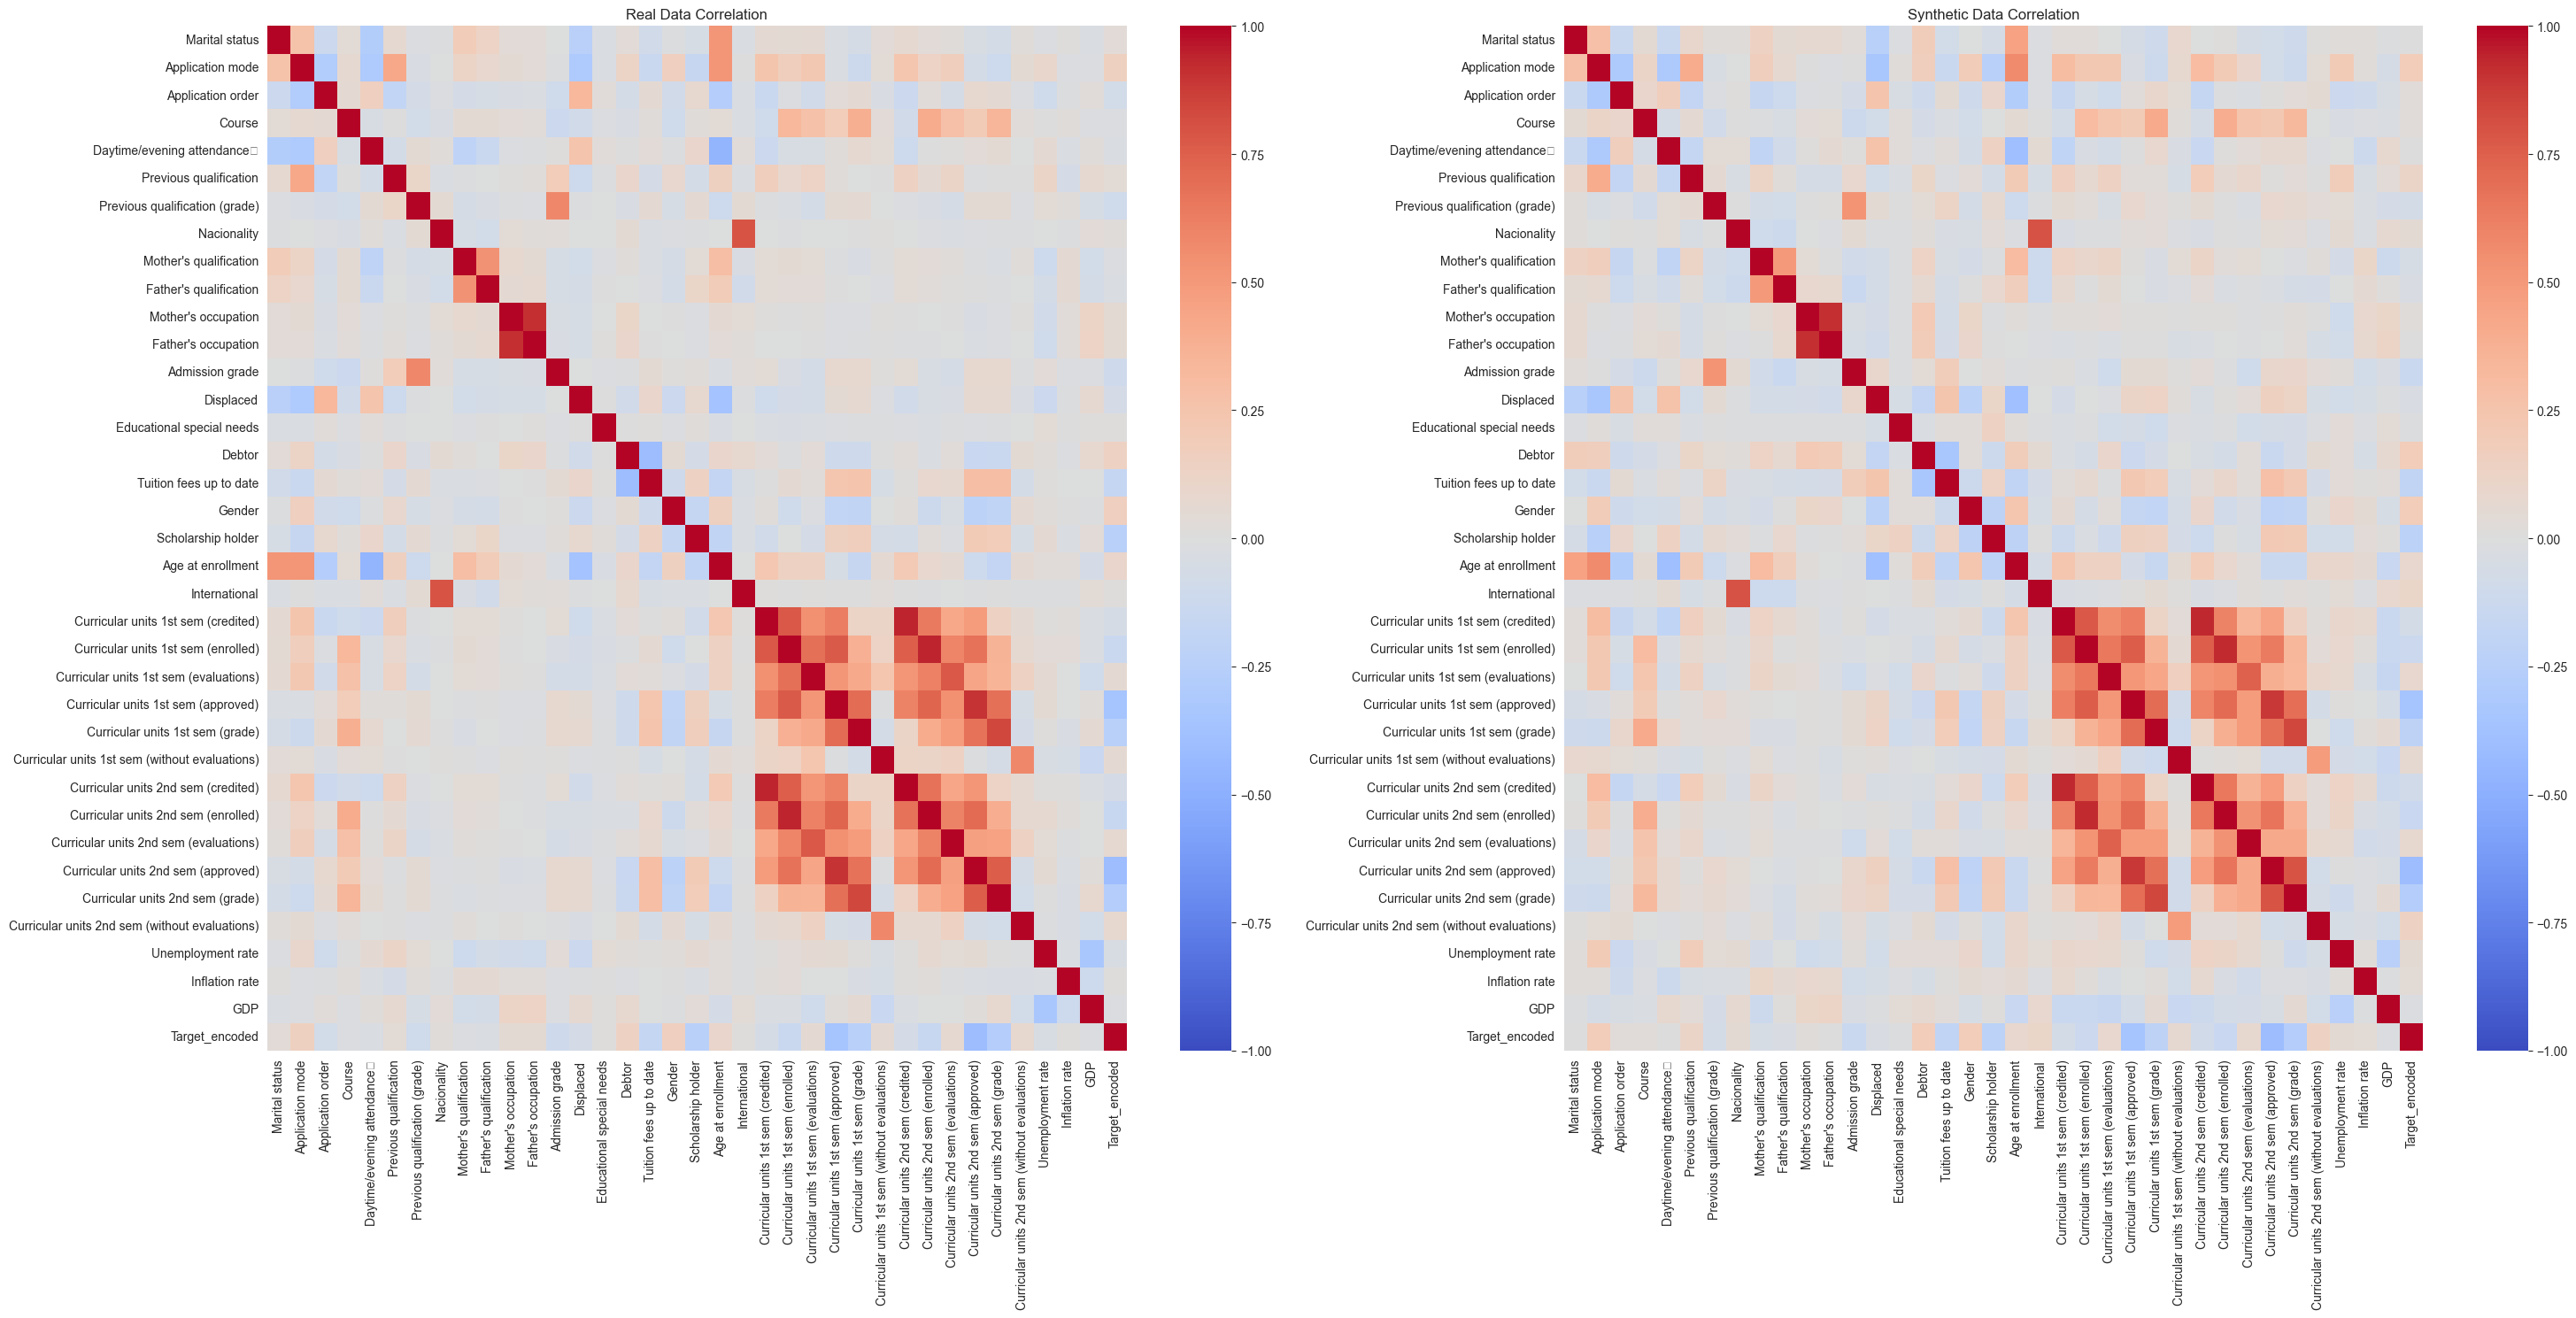

In [90]:
compare_correlation_matrices(df, df_deepseek)

# Original VS Copilot's datasets

D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
D:\LLM_exp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


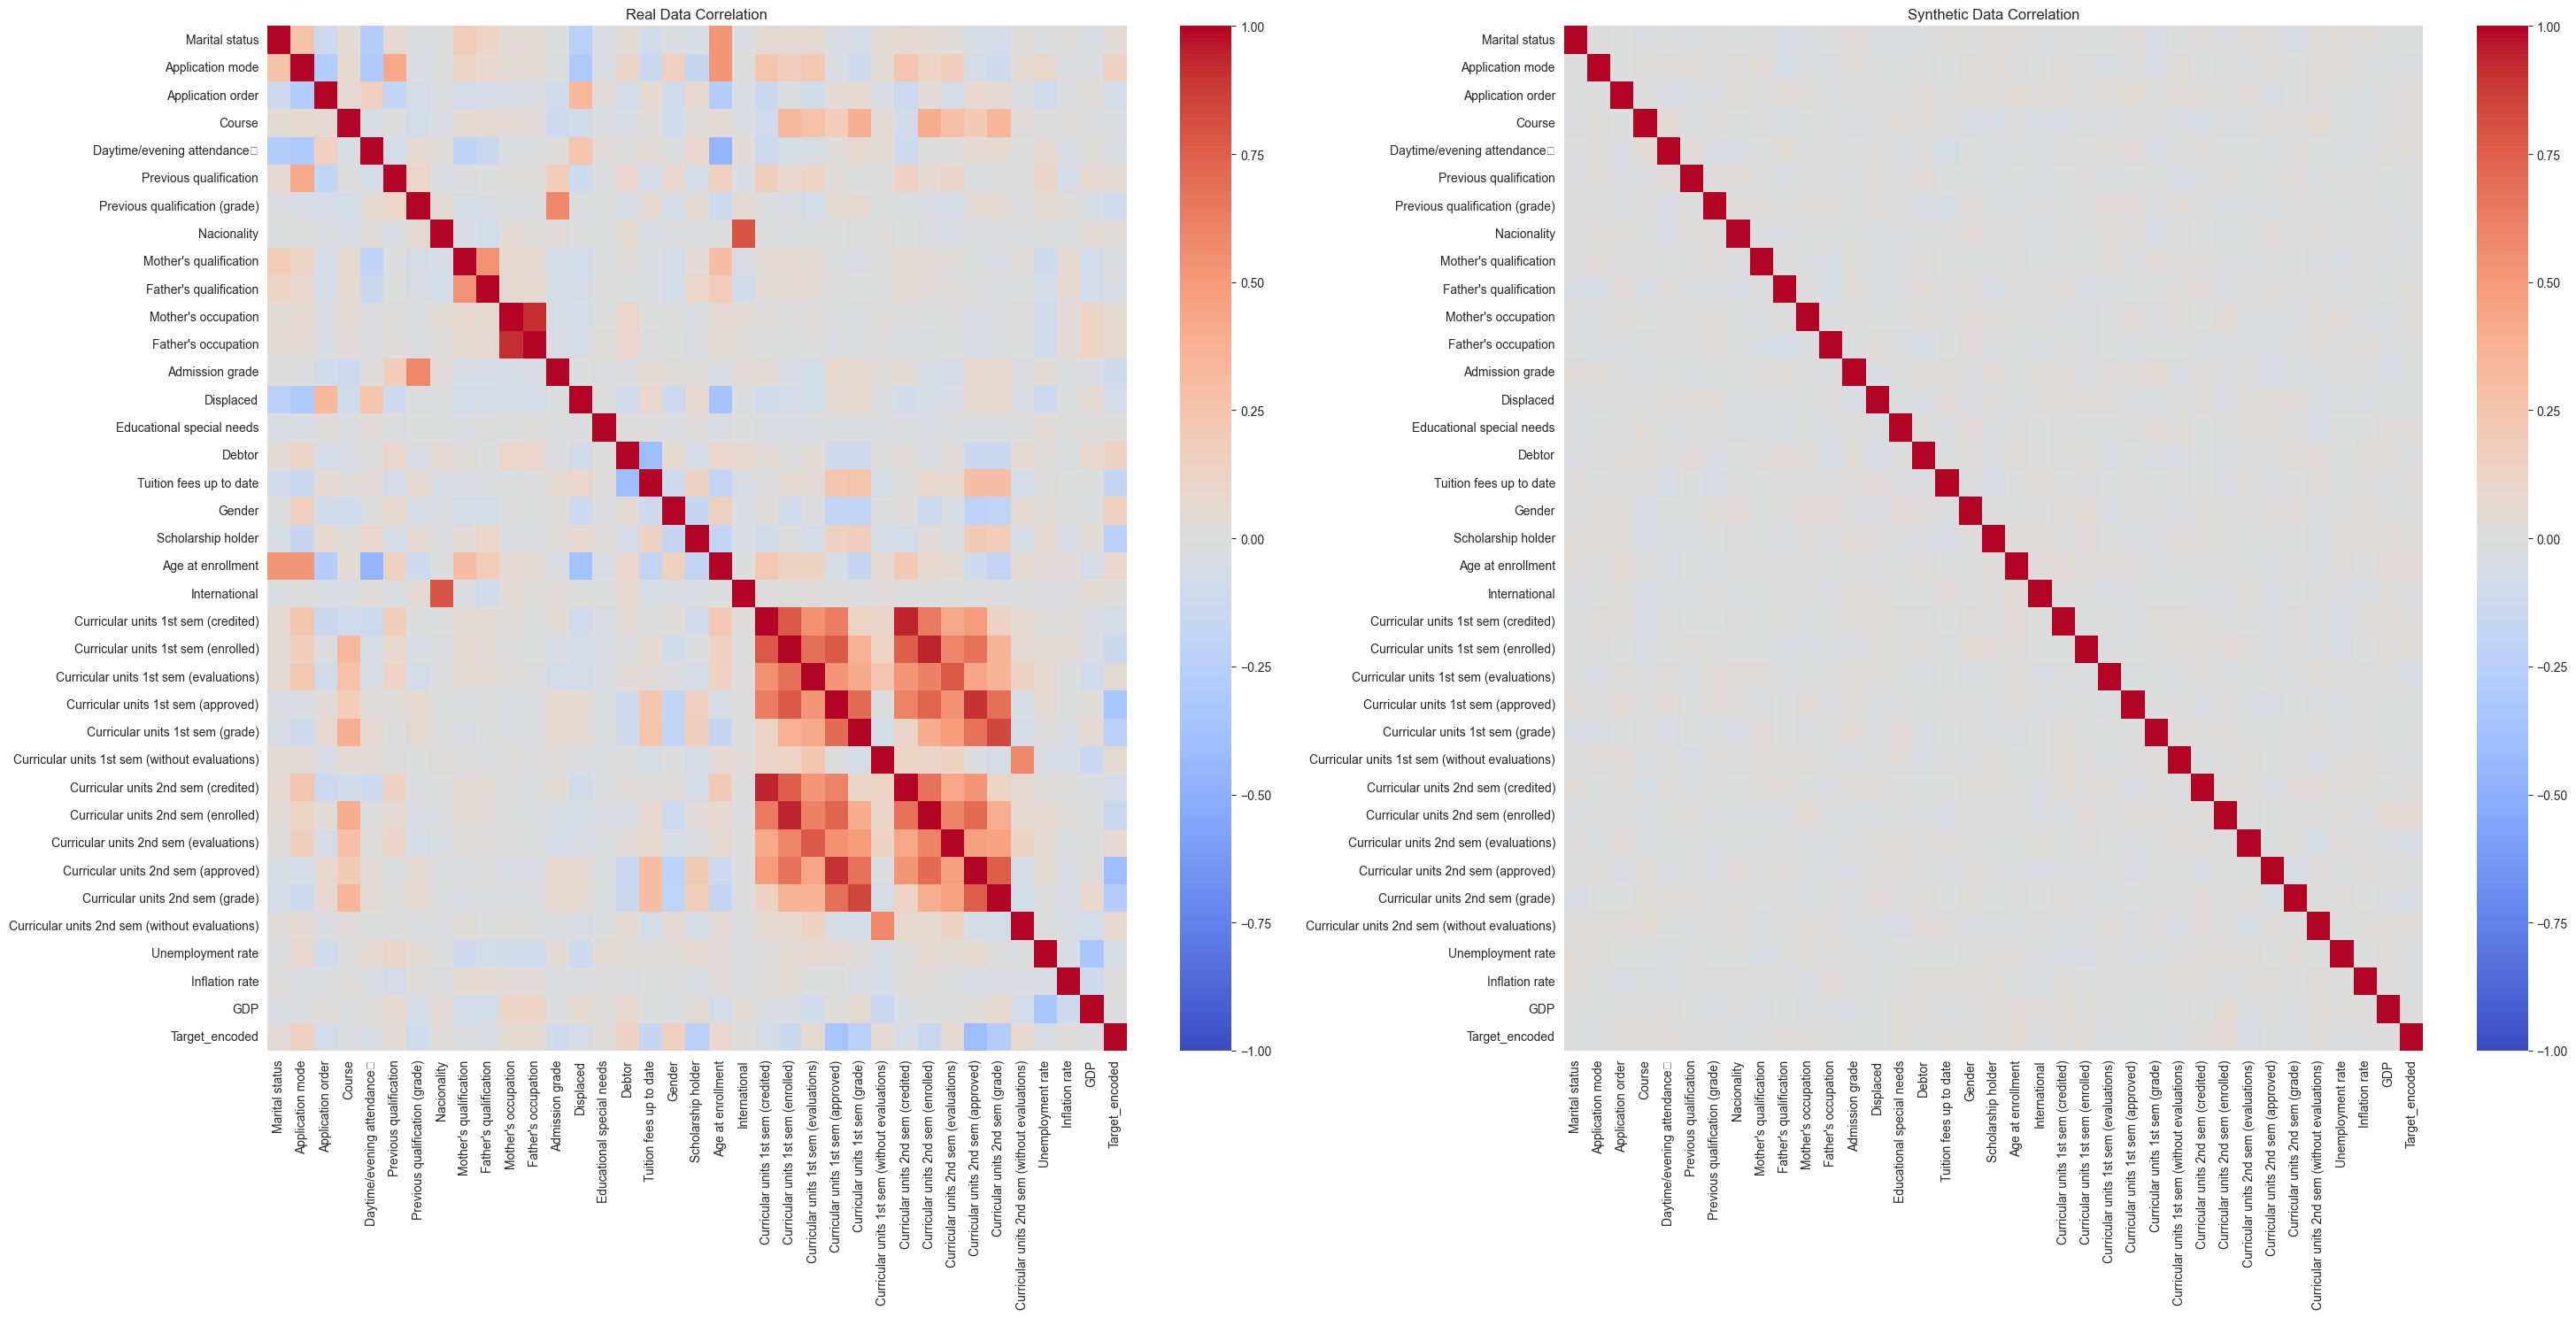

In [91]:
compare_correlation_matrices(df, df_copilot)